In [1]:
import os
import re
import json
import utils
import random
import gensim
import warnings

import numpy as np
import pandas as pd

from tasks import *
from pprint import pprint
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
warnings.filterwarnings('ignore')

In [2]:
biorxiv_dir = 'data/biorxiv_medrxiv/biorxiv_medrxiv/'
filenames = os.listdir(biorxiv_dir)
print("Number of articles retrieved from biorxiv:", len(filenames))

Number of articles retrieved from biorxiv: 885


In [3]:
all_files = []

for filename in filenames:
    filename = biorxiv_dir + filename
    file = json.load(open(filename, 'rb'))
    all_files.append(file)
    
all_files[0]

{'paper_id': 'a83b9f98ccbd6dd76d47c49cfe5785f9c2ecc09e',
 'metadata': {'title': 'Large-scale Lassa fever outbreaks in Nigeria: quantifying the association between disease reproduction number and local rainfall',
  'authors': [{'first': 'Shi',
    'middle': [],
    'last': 'Zhao',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Hong Kong Polytechnic University',
     'location': {'settlement': 'Hong Kong', 'country': 'China'}},
    'email': ''},
   {'first': 'Salihu',
    'middle': ['S'],
    'last': 'Musa',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'Hong Kong Polytechnic University',
     'location': {'settlement': 'Hong Kong', 'country': 'China'}},
    'email': ''},
   {'first': 'Hao',
    'middle': [],
    'last': 'Fu',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'South China Agricultural University',
     'location': {'settlement': 'Guangzhou', 'country': 'China'}},
    'email': ''},
   {'

In [4]:
cleaned_files = []

for file in tqdm(all_files):
    features = [
        file['paper_id'],
        file['metadata']['title'],
        utils.format_authors(file['metadata']['authors']),
        utils.format_authors(file['metadata']['authors'], 
                       with_affiliation = True),
        utils.format_body(file['abstract']),
        utils.format_body(file['body_text']),
        utils.format_bib(file['bib_entries']),
        file['metadata']['authors'],
        file['bib_entries']
    ]
    
    cleaned_files.append(features)
    
cleaned_files[0]

['a83b9f98ccbd6dd76d47c49cfe5785f9c2ecc09e',
 'Large-scale Lassa fever outbreaks in Nigeria: quantifying the association between disease reproduction number and local rainfall',
 'Shi Zhao, Salihu S Musa, Hao Fu, Daihai He, Jing Qin',
 'Shi Zhao (Hong Kong Polytechnic University, Hong Kong, China), Salihu S Musa (Hong Kong Polytechnic University, Hong Kong, China), Hao Fu (South China Agricultural University, Guangzhou, China), Daihai He (Hong Kong Polytechnic University, Hong Kong, China), Jing Qin (Hong Kong Polytechnic University, Hong Kong, China)',
 "Background Lassa fever (LF) is increasingly recognized as an important rodent-borne viral hemorrhagic fever presenting a severe public health threat to sub-Saharan West Africa. In 2018, LF caused an unprecedented outbreak in Nigeria, and the situation was worse in 2019. This work aims to study the epidemiological features of outbreaks in different Nigerian regions and quantify the association between reproduction number (R) and local 

In [5]:
col_names = [
    'paper_id', 
    'title', 
    'authors',
    'affiliations', 
    'abstract', 
    'text', 
    'bibliography',
    'raw_authors',
    'raw_bibliography'
]

clean_df = pd.DataFrame(cleaned_files, columns = col_names)
clean_df.head(2)

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,a83b9f98ccbd6dd76d47c49cfe5785f9c2ecc09e,Large-scale Lassa fever outbreaks in Nigeria: ...,"Shi Zhao, Salihu S Musa, Hao Fu, Daihai He, Ji...","Shi Zhao (Hong Kong Polytechnic University, Ho...",Background Lassa fever (LF) is increasingly re...,"Lassa fever (LF), caused by Lassa virus (LASV)...",Understanding the cryptic nature of Lassa feve...,"[{'first': 'Shi', 'middle': [], 'last': 'Zhao'...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Underst..."
1,b4edd81e0d2770b0d6e0e3c93c7fffc43e3caa80,Role of temperature and humidity in the modula...,"B Oliveiros, ; L Caramelo, ; N C Ferreira, ; F...","B Oliveiros (University of Coimbra, Portugal),...",COVID-19 is having a great impact on public he...,"The outbreak of pneumonia cases in Wuhan, Chin...",World Health Organization. Novel coronavirus -...,"[{'first': 'B', 'middle': [], 'last': 'Oliveir...","{'BIBREF0': {'ref_id': 'b0', 'title': 'World H..."


In [6]:
pmc_dir = 'data/custom_license/custom_license/'
pmc_files = utils.load_files(pmc_dir)
pmc_df = utils.generate_clean_df(pmc_files)

100%|██████████| 16959/16959 [00:48<00:00, 352.28it/s]


In [7]:
pmc_df.head(2)

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,6f005a0677f24f697c1ec3ce065ec4144519e357,Antiviral Mechanisms of Human Defensins Introd...,"Sarah S Wilson, Mayim E Wiens, Jason G Smith","Sarah S Wilson (University of Washington, 1705...",Defensins are an effector component of the inn...,Defensins are one of the most abundant classes...,Direct inactivation of viruses by human granul...,"[{'first': 'Sarah', 'middle': ['S'], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Direct ..."
1,c4c5a6fd756afc5414847e5f83feb0478117db04,EFFECTS OF INTRAVENOUSLY INFUSED FLUOSOL-DA 20...,"Laurie West, B A , Norma Mcintosh, Simona Gend...","Laurie West (Alpha Therapeutic Corporation, 55...",Rats were injected with a fractionated 50 ml/k...,Oxygen has been recognized as a powerful radio...,Perfluorochemical emulsions in cancer therapy:...,"[{'first': 'Laurie', 'middle': [], 'last': 'We...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Perfluo..."


In [8]:
comm_dir = 'data/comm_use_subset/comm_use_subset/'
comm_files = utils.load_files(comm_dir)
comm_df = utils.generate_clean_df(comm_files)

100%|██████████| 9118/9118 [00:28<00:00, 318.72it/s]


In [9]:
comm_df.head(2)

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,4994fa72322bbf19120592304d92629226948d8e,Rapid Identification of Malaria Vaccine Candid...,"V Villard, G W Agak, G Frank, A Jafarshad, C S...","V Villard, G W Agak, G Frank, A Jafarshad, C S...",To identify malaria antigens for vaccine devel...,Human Plasmodium falciparum (Pf) infection is ...,Identification of vaccine candidates against s...,"[{'first': 'V', 'middle': [], 'last': 'Villard...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Identif..."
1,c2676bad025d5a255889b8a699c86711223e3a63,Triterpene Constituents of Euphorbia Erythrade...,"Abdul Majid Ayatollahi, Seyed Mohammad Zarei, ...",Abdul Majid Ayatollahi (Shahid Beheshti Univer...,Phytochemical investigation of the aerial part...,The genus Euphorbia is the largest among the p...,Chemistry and biological activity of secondary...,"[{'first': 'Abdul', 'middle': [], 'last': 'Maj...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Chemist..."


In [10]:
noncomm_dir = 'data/noncomm_use_subset/noncomm_use_subset/'
noncomm_files = utils.load_files(noncomm_dir)
noncomm_df = utils.generate_clean_df(noncomm_files)

100%|██████████| 2353/2353 [00:05<00:00, 445.84it/s]


In [11]:
noncomm_df.head(2)

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,5c1dd2b19bb6b3016ba2654f69905bf4ec65bd54,"""Running the Gauntlet"": Formidable challenges ...","Maria Elena Bottazzi, Peter J Hotez","Maria Elena Bottazzi (Baylor University, Waco,...",Translational science for new biotechnologies ...,The translation of basic biomedical research d...,"Austin CP Translating translation, , Nat Rev D...","[{'first': 'Maria', 'middle': ['Elena'], 'last...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Austin ..."
1,8ee4731a0d1dabf9a61a177aed392c62ca6fb69b,,,,,". Since then, several cases of MERS-CoV infect...",Isolation of a novel coronavirus from a man wi...,[],"{'BIBREF0': {'ref_id': 'b0', 'title': 'Isolati..."


In [12]:
complete_df = pd.concat([clean_df, pmc_df, comm_df, noncomm_df])
complete_df.shape

(29315, 9)

In [13]:
complete_df.head(2)

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
0,a83b9f98ccbd6dd76d47c49cfe5785f9c2ecc09e,Large-scale Lassa fever outbreaks in Nigeria: ...,"Shi Zhao, Salihu S Musa, Hao Fu, Daihai He, Ji...","Shi Zhao (Hong Kong Polytechnic University, Ho...",Background Lassa fever (LF) is increasingly re...,"Lassa fever (LF), caused by Lassa virus (LASV)...",Understanding the cryptic nature of Lassa feve...,"[{'first': 'Shi', 'middle': [], 'last': 'Zhao'...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Underst..."
1,b4edd81e0d2770b0d6e0e3c93c7fffc43e3caa80,Role of temperature and humidity in the modula...,"B Oliveiros, ; L Caramelo, ; N C Ferreira, ; F...","B Oliveiros (University of Coimbra, Portugal),...",COVID-19 is having a great impact on public he...,"The outbreak of pneumonia cases in Wuhan, Chin...",World Health Organization. Novel coronavirus -...,"[{'first': 'B', 'middle': [], 'last': 'Oliveir...","{'BIBREF0': {'ref_id': 'b0', 'title': 'World H..."


In [14]:
# Keep only texts with minimal number of words 

complete_df = complete_df[complete_df['text'].apply(lambda x: len(re.findall(r"(?i)\b[a-z]+\b", x))) > 1000]                                           
complete_df.shape

(27139, 9)

In [15]:
# See random text

complete_df.reset_index(inplace = True, drop = True)
complete_df.iloc[42]['text'][:500]

'The flavivirus Zika virus (ZIKV) activates ribonuclease L (RNase L) catalytic antiviral 26 function during infection, yet deletion of RNase L decreases ZIKV production, suggesting 27 a proviral role of RNase L. In this study, we reveal that latent RNase L supports ZIKV 28 replication factory (RF) assembly. Deletion of RNase L induced broader cellular 29 distribution of ZIKV dsRNA and NS3 compared with densely concentrated RFs detected 30 in WT cells. An inactive form of RNase L was sufficient to'

In [16]:
frac_of_articles = 1
train_df  = complete_df.sample(frac = frac_of_articles, random_state = 42)
train_corpus = (list(utils.read_corpus(train_df, 'abstract'))) 

In [17]:
# Using distributed memory model

model = gensim.models.doc2vec.Doc2Vec(dm = 1, vector_size = 50, min_count = 10, dm_mean = 1, epochs = 20, seed = 42, workers = 6)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples = model.corpus_count, epochs = model.epochs)

In [18]:
list_of_tasks = [task_1, task_2, task_3, task_4, task_5, task_6, task_7, task_8, task_9]

In [19]:
abstract_vectors = model.docvecs.vectors_docs
array_of_tasks = [utils.get_doc_vector(task, model) for task in list_of_tasks]

In [20]:
train_df['abstract_vector'] = [vec for vec in abstract_vectors]

### Nearest Neigbors search

In [21]:
train_df = train_df[train_df['abstract'].apply(lambda x: len(re.findall(r"(?i)\b[a-z]+\b", x))) > 40]
train_df.shape

(20123, 10)

In [22]:
train_array = train_df['abstract_vector'].values.tolist()

In [23]:
ball_tree = NearestNeighbors(algorithm = 'ball_tree', leaf_size = 20).fit(train_array)

In [24]:
# Query for all tasks

distances, indices = ball_tree.kneighbors(array_of_tasks, n_neighbors = 3)

In [25]:
for i, info in enumerate(list_of_tasks):
    print("="*80, f"\n\nTask = {info[:100]}\n", )
    df =  train_df.iloc[indices[i]]
    abstracts = df['abstract']
    titles = df['title']
    dist = distances[i]
    for l in range(len(dist)):
        print(f" Text index = {indices[i][l]} \n Distance = {distances[i][l]} \n Title: {titles.iloc[l]} \n Abstract extract: {abstracts.iloc[l][:200]}\n\n")


Task = What is known about transmission, incubation, and environmental stability of COVID-19? What do we kn

 Text index = 20066 
 Distance = 5.307023922482975 
 Title: A Review and Update on Waterborne Viral Diseases Associated with Swimming Pools 
 Abstract extract: Infectious agents, including bacteria, viruses, protozoa, and molds, may threaten the health of swimming pool bathers. Viruses are a major cause of recreationally-associated waterborne diseases linked


 Text index = 11461 
 Distance = 5.390906338478335 
 Title: Dynamic Transmission Modeling: A Report of the ISPOR-SMDM Modeling Good Research Practices Task Force-5 
 Abstract extract: The transmissible nature of communicable diseases is what sets them apart from other diseases modeled by health economists. The probability of a susceptible individual becoming infected at any one poi


 Text index = 7909 
 Distance = 5.409568836534897 
 Title: PUBLIC HEALTH REVIEW ARTICLE Animal viruses, bacteria, and cancer: a brief commen

### Clustering and visualisation

/home/tanmay/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


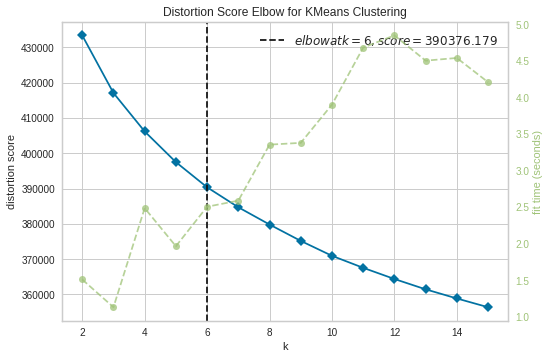

In [27]:
abstract_vectors = model.docvecs.vectors_docs
kmeans = KMeans(init = 'k-means++', max_iter = 300, random_state = 42) 
visualizer = KElbowVisualizer(kmeans, k = (2, 16))
visualizer.fit(abstract_vectors)
visualizer.show()

In [28]:
# Clearly 6 clusters are here

In [29]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 100, random_state = 42) 
train_df['labels'] = kmeans.fit_predict(train_array)

In [38]:
train_df[['text','labels']][:20]

,text,labels
10352,Although viral disease remains a major cause o...,1
10007,Cationic One research area in the emergent pop...,4
4093,Canine visceral leishmaniasis (CVL) is caused ...,4
5799,Coronaviruses are single stranded positive sen...,4
21052,E merging and re-emerging diseases caused by i...,4
18947,"Presently, lack of proper therapeutics and vac...",4
20653,An essential step in understanding protein fun...,4
7998,"The management of comprehensive and extensive,...",0
16598,Leptospirosis is a worldwide zoonotic disease ...,4
20763,inTrODUcTiOn Porcine epidemic diarrhea (PED) i...,1
